# 11_2_LEARN-DataAnalysisML

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/11_2_LEARN_DataAnalysisML.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [68]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# cloning the data repo
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


## 1. Setup H2O AutoML

In [3]:
%%capture 
!pip install h2o

In [4]:
import h2o
from h2o.automl import H2OAutoML

In [5]:
# If this doesnt work - install java. 
# Start the H2O cluster (locally)
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_351"; Java(TM) SE Runtime Environment (build 1.8.0_351-b10); Java HotSpot(TM) 64-Bit Server VM (build 25.351-b10, mixed mode)
  Starting server from /Users/lucaslevassor/opt/anaconda3/envs/constrain/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmpuqzamgm0
  JVM stdout: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmpuqzamgm0/h2o_lucaslevassor_started_from_python.out
  JVM stderr: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmpuqzamgm0/h2o_lucaslevassor_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O_cluster_uptime:,21 secs
H2O_cluster_timezone:,Europe/Copenhagen
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,4 months and 12 days !!!
H2O_cluster_name:,H2O_from_python_lucaslevassor_2b05et
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


### 1.1 Import our dataframe as h20 object

Train a model based on the target and the df

In [20]:
first_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_1st_iteration_all_analytics.csv')
first_input_for_ml 

,Unnamed: 0,Line_name,0,1,2,3,norm_strict_x,norm_strict_y,norm_strict_mean
0,0,yp49_A01,1,2,5,1,0.972701,1.796170,1.384435
1,1,yp49_C01,1,2,5,9,0.536658,0.738584,0.637621
2,2,yp49_D01,2,4,7,3,0.175896,0.109680,0.142788
3,3,yp49_E01,2,1,5,7,0.345201,0.228028,0.286614
4,4,yp49_F01,3,3,6,1,26.416324,23.762944,25.089634
...,...,...,...,...,...,...,...,...,...
164,164,yp51_C12,8,3,7,2,0.000000,0.089923,0.044961
165,165,yp51_D12,8,2,7,6,0.614962,1.264863,0.939912
166,166,yp51_E12,8,1,6,10,0.466688,2.068186,1.267437
167,167,yp50_F05,6,1,8,2,15.155009,12.813656,13.984332


In [38]:
# Run ML with new input 
second_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_2nd_iteration_all_analytics.csv')
second_input_for_ml

,Unnamed: 0,Line_name,0,1,2,3,norm_strict_x,norm_strict_y,norm_strict_mean
0,0,yp53_A01,4,1,5,2,9.058562,5.196491,7.127526
1,1,yp53_A02,4,1,5,2,28.175952,16.525934,22.350943
2,2,yp53_A04,4,2,5,2,80.375862,66.154223,73.265043
3,3,yp53_A06,5,1,5,2,121.767572,107.215440,114.491506
4,4,yp53_A07,5,2,6,2,159.059724,144.151010,151.605367
...,...,...,...,...,...,...,...,...,...
124,232,yp54_A04,4,1,6,1,15.322951,13.201487,14.262219
125,233,yp54_C04,5,2,6,3,94.318358,71.892536,83.105447
126,234,yp54_C09,3,1,6,3,46.469517,29.678034,38.073775
127,235,yp54_D12,5,1,6,6,3.718051,1.356013,2.537032


In [39]:
new_input_for_ml = pd.concat([first_input_for_ml,second_input_for_ml ])
new_input_for_ml

,Unnamed: 0,Line_name,0,1,2,3,norm_strict_x,norm_strict_y,norm_strict_mean
0,0,yp49_A01,1,2,5,1,0.972701,1.796170,1.384435
1,1,yp49_C01,1,2,5,9,0.536658,0.738584,0.637621
2,2,yp49_D01,2,4,7,3,0.175896,0.109680,0.142788
3,3,yp49_E01,2,1,5,7,0.345201,0.228028,0.286614
4,4,yp49_F01,3,3,6,1,26.416324,23.762944,25.089634
...,...,...,...,...,...,...,...,...,...
124,232,yp54_A04,4,1,6,1,15.322951,13.201487,14.262219
125,233,yp54_C04,5,2,6,3,94.318358,71.892536,83.105447
126,234,yp54_C09,3,1,6,3,46.469517,29.678034,38.073775
127,235,yp54_D12,5,1,6,6,3.718051,1.356013,2.537032


In [40]:
new_input_for_ml['default_rank'] = new_input_for_ml['norm_strict_mean'].rank()
new_input_for_ml['max_rank'] = new_input_for_ml['norm_strict_mean'].rank(method='max')
new_input_for_ml['NA_bottom'] = new_input_for_ml['norm_strict_mean'].rank(na_option='bottom')
new_input_for_ml['pct_rank'] = new_input_for_ml['norm_strict_mean'].rank(pct=True)
new_input_for_ml = new_input_for_ml.sort_values(by= 'NA_bottom', ascending = False)

new_input_for_ml

,Unnamed: 0,Line_name,0,1,2,3,norm_strict_x,norm_strict_y,norm_strict_mean,default_rank,max_rank,NA_bottom,pct_rank
75,75,yp50_D03,5,2,6,3,277.307816,124.097492,200.702654,298.0,298.0,298.0,1.000000
21,21,yp49_F04,3,2,6,2,138.940568,173.866982,156.403775,297.0,297.0,297.0,0.996644
42,51,yp53_E02,6,2,6,5,145.152656,163.941847,154.547251,296.0,296.0,296.0,0.993289
4,4,yp53_A07,5,2,6,2,159.059724,144.151010,151.605367,295.0,295.0,295.0,0.989933
27,36,yp53_C07,6,2,6,4,126.638026,173.503553,150.070790,294.0,294.0,294.0,0.986577
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,180,yp54_D09,5,1,6,6,0.000000,0.000000,0.000000,13.0,25.0,13.0,0.043624
105,181,yp54_D10,5,1,6,6,0.000000,0.000000,0.000000,13.0,25.0,13.0,0.043624
26,26,yp49_E05,2,3,7,8,0.000000,0.000000,0.000000,13.0,25.0,13.0,0.043624
108,190,yp54_E02,6,1,6,6,0.000000,0.000000,0.000000,13.0,25.0,13.0,0.043624


### 1.2 Update dataframe Change 

In [41]:
new_input_for_ml = new_input_for_ml[['Line_name', '0','1','2','3','norm_strict_x']]
new_input_for_ml.columns = ['Line_name', '0','1','2','3','Amt_norm']
new_input_for_ml

,Line_name,0,1,2,3,Amt_norm
75,yp50_D03,5,2,6,3,277.307816
21,yp49_F04,3,2,6,2,138.940568
42,yp53_E02,6,2,6,5,145.152656
4,yp53_A07,5,2,6,2,159.059724
27,yp53_C07,6,2,6,4,126.638026
...,...,...,...,...,...,...
104,yp54_D09,5,1,6,6,0.000000
105,yp54_D10,5,1,6,6,0.000000
26,yp49_E05,2,3,7,8,0.000000
108,yp54_E02,6,1,6,6,0.000000


In [42]:
df_test = h2o.H2OFrame(pd.concat([new_input_for_ml], axis='columns'))
df_test.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Rows:298
Cols:6




,Line_name,0,1,2,3,Amt_norm
type,string,int,int,int,int,real
mins,NaN,1.0,1.0,5.0,1.0,0.0
mean,NaN,4.761744966442952,2.144295302013422,6.137583892617449,4.758389261744967,28.932462303045384
maxs,NaN,8.0,4.0,8.0,10.0,277.3078163064027
sigma,NaN,1.9454547672041116,1.1113059960605862,1.0530684048668946,2.586291253376485,46.060107369420486
zeros,0,0,0,0,0,72
missing,0,0,0,0,0,0
0,yp50_D03,5.0,2.0,6.0,3.0,277.3078163064027
1,yp49_F04,3.0,2.0,6.0,2.0,138.940567699116
2,yp53_E02,6.0,2.0,6.0,5.0,145.15265551287143


In [43]:
# Since the data is categorical we need to make it from numerical to categorical 
df_test['0']= df_test['0'].asfactor()
df_test['1']= df_test['1'].asfactor()
df_test['2'] = df_test['2'].asfactor()
df_test['3'] = df_test['3'].asfactor()

In [44]:
df_test.describe()

Rows:298
Cols:6




,Line_name,0,1,2,3,Amt_norm
type,string,enum,enum,enum,enum,real
mins,NaN,,,,,0.0
mean,NaN,,,,,28.932462303045384
maxs,NaN,,,,,277.3078163064027
sigma,NaN,,,,,46.060107369420486
zeros,0,,,,,72
missing,0,0,0,0,0,0
0,yp50_D03,5,2,6,3,277.3078163064027
1,yp49_F04,3,2,6,2,138.940567699116
2,yp53_E02,6,2,6,5,145.15265551287143


Set some arguments for the autoML. 


Important here is that we dont split the dataset but rather keep the cross-validation validate a model internally, i.e., estimate the model performance without having to sacrifice a validation split. See: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html


## 2 RUN automl

Here we are defining the autoML object and after we can train it

In [45]:
# Select the columns we want to train on
feature_cols = ['0', '1', '2', '3']

# Initialize H2O autoML class
AutoML = H2OAutoML(
    max_runtime_secs=20,  # 1 hour =int(3600 * 1) , if unlimited time is wanted then set this to zero = 0
    max_models=None,  # None =  no limit
    nfolds=5,         # number of folds for k-fold cross-validation (nfolds=0 disables cross-validation)
    seed=1,            # Reproducibility
    exclude_algos = ["StackedEnsemble"],
    keep_cross_validation_predictions=True 
)

Train a model based on the target and the df. 


It has been Commented out and saved as showed below

In [46]:
%%time

AutoML.train(
     x=feature_cols,
     y='Amt_norm',
     training_frame=df_test,
 )


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 429 ms, sys: 51.3 ms, total: 480 ms
Wall time: 21.6 s
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_1_20221121_154943_model_20


Model Summary: 


,,number_of_trees
0,,63.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 537.9312339733298
RMSE: 23.19334460515192
MAE: 13.316106598712535
RMSLE: NaN
Mean Residual Deviance: 537.9312339733298

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 775.7834280312472
RMSE: 27.852889042812905
MAE: 17.112990436901264
RMSLE: NaN
Mean Residual Deviance: 775.7834280312472

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,17.104185,3.115596,20.793112,16.077423,17.065971,19.011010,12.573413
1,mean_residual_deviance,774.520750,355.025880,1352.329000,651.480470,696.024700,784.147950,388.621800
2,mse,774.520750,355.025880,1352.329000,651.480470,696.024700,784.147950,388.621800
3,r2,0.644187,0.095588,0.515384,0.703791,0.602539,0.634314,0.764908
4,residual_deviance,774.520750,355.025880,1352.329000,651.480470,696.024700,784.147950,388.621800
5,rmse,27.279310,6.160353,36.774025,25.524115,26.382280,28.002642,19.713493
6,rmsle,NaN,0.000000,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-11-21 15:49:57,4.634 sec,0.0,54.063104,28.710615,2922.819172
1,,2022-11-21 15:49:57,4.640 sec,5.0,40.400629,21.666084,1632.210844
2,,2022-11-21 15:49:57,4.644 sec,10.0,34.226471,18.870009,1171.451330
3,,2022-11-21 15:49:57,4.647 sec,15.0,30.698010,17.426964,942.367813
4,,2022-11-21 15:49:57,4.651 sec,20.0,28.544105,16.419830,814.765931
5,,2022-11-21 15:49:57,4.655 sec,25.0,27.092315,15.564595,733.993513
6,,2022-11-21 15:49:57,4.659 sec,30.0,26.095463,15.076009,680.973204
7,,2022-11-21 15:49:57,4.663 sec,35.0,25.370025,14.597433,643.638172
8,,2022-11-21 15:49:57,4.668 sec,40.0,24.817060,14.334839,615.886471
9,,2022-11-21 15:49:57,4.673 sec,45.0,24.390428,14.040609,594.892964



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,1.2,67580.226562,1.000000,0.171223
1,3.7,48113.027344,0.711939,0.121900
2,3.6,42159.843750,0.623849,0.106817
3,0.5,31498.160156,0.466085,0.079804
4,1.4,28856.804688,0.427001,0.073112
5,1.3,25776.285156,0.381418,0.065307
6,2.7,25517.841797,0.377593,0.064652
7,0.1,23725.412109,0.351070,0.060111
8,2.8,12999.130859,0.192351,0.032935
9,2.6,12222.108398,0.180853,0.030966



See the whole table with table.as_data_frame()


In [47]:
print('DOOOOOOONE')

DOOOOOOONE


## 3. Processing model


In [48]:
# saving the models
leaderboard = AutoML.leaderboard
model_ids = list(leaderboard['model_id'].as_data_frame().iloc[:,0])


# get rid of models with stacked ensemble - they; the tree-based models, the tree ensemble (GBM or Random Forest) ends up memorizing the training data.
#The model has a poor time generalizing on validation data
for model in model_ids:
    if 'StackedEnsemble' in model:
        model_ids.remove(model)

out_path = 'ConStrain_on_google_colab/Data/processed/ML_second_lib_leaderbords'

for m_id in model_ids:
     mdl = h2o.get_model(m_id)
     h2o.save_model(model=mdl, path=out_path, force=True)


In [49]:
len(model_ids)

55

Now we want to extract the best models that are not StackedEnsemble

In [50]:
df_from_h2o_object = leaderboard.as_data_frame(use_pandas=True, header=True)
df_from_h2o_object

,model_id,rmse,mse,mae,rmsle,mean_residual_deviance
0,XGBoost_grid_1_AutoML_1_20221121_154943_model_20,27.852889,775.783428,17.112990,NaN,775.783428
1,GBM_grid_1_AutoML_1_20221121_154943_model_2,27.920090,779.531431,15.468341,NaN,779.531431
2,GBM_4_AutoML_1_20221121_154943,28.530162,813.970122,16.998499,NaN,813.970122
3,GBM_3_AutoML_1_20221121_154943,28.572019,816.360291,17.058872,NaN,816.360291
4,GBM_grid_1_AutoML_1_20221121_154943_model_5,28.618942,819.043822,16.296347,NaN,819.043822
5,GBM_2_AutoML_1_20221121_154943,28.699595,823.666780,16.603375,NaN,823.666780
6,XGBoost_grid_1_AutoML_1_20221121_154943_model_16,29.077736,845.514751,18.895104,NaN,845.514751
7,XGBoost_grid_1_AutoML_1_20221121_154943_model_7,29.214767,853.502633,18.238886,NaN,853.502633
8,GBM_grid_1_AutoML_1_20221121_154943_model_8,29.593838,875.795256,19.786443,NaN,875.795256
9,XGBoost_grid_1_AutoML_1_20221121_154943_model_23,29.611591,876.846305,19.060996,NaN,876.846305


In [51]:
index_to_delete = []
for index, row in df_from_h2o_object.iterrows():
    if 'StackedEnsemble' in row['model_id']:
        index_to_delete.append(index)

data_wo_ensemble = df_from_h2o_object.drop(labels=index_to_delete, axis=0)
final_df = h2o.H2OFrame(data_wo_ensemble)
final_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
XGBoost_grid_1_AutoML_1_20221121_154943_model_20,27.8529,775.783,17.113,nan,775.783
GBM_grid_1_AutoML_1_20221121_154943_model_2,27.9201,779.531,15.4683,nan,779.531
GBM_4_AutoML_1_20221121_154943,28.5302,813.97,16.9985,nan,813.97
GBM_3_AutoML_1_20221121_154943,28.572,816.36,17.0589,nan,816.36
GBM_grid_1_AutoML_1_20221121_154943_model_5,28.6189,819.044,16.2963,nan,819.044
GBM_2_AutoML_1_20221121_154943,28.6996,823.667,16.6034,nan,823.667
XGBoost_grid_1_AutoML_1_20221121_154943_model_16,29.0777,845.515,18.8951,nan,845.515
XGBoost_grid_1_AutoML_1_20221121_154943_model_7,29.2148,853.503,18.2389,nan,853.503
GBM_grid_1_AutoML_1_20221121_154943_model_8,29.5938,875.795,19.7864,nan,875.795
XGBoost_grid_1_AutoML_1_20221121_154943_model_23,29.6116,876.846,19.061,nan,876.846


### 3.1 Saving the best model

In [52]:
best_model = AutoML.get_best_model()
best_model

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_1_20221121_154943_model_20


Model Summary: 


,,number_of_trees
0,,63.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 537.9312339733298
RMSE: 23.19334460515192
MAE: 13.316106598712535
RMSLE: NaN
Mean Residual Deviance: 537.9312339733298

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 775.7834280312472
RMSE: 27.852889042812905
MAE: 17.112990436901264
RMSLE: NaN
Mean Residual Deviance: 775.7834280312472

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,17.104185,3.115596,20.793112,16.077423,17.065971,19.011010,12.573413
1,mean_residual_deviance,774.520750,355.025880,1352.329000,651.480470,696.024700,784.147950,388.621800
2,mse,774.520750,355.025880,1352.329000,651.480470,696.024700,784.147950,388.621800
3,r2,0.644187,0.095588,0.515384,0.703791,0.602539,0.634314,0.764908
4,residual_deviance,774.520750,355.025880,1352.329000,651.480470,696.024700,784.147950,388.621800
5,rmse,27.279310,6.160353,36.774025,25.524115,26.382280,28.002642,19.713493
6,rmsle,NaN,0.000000,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-11-21 15:49:57,4.634 sec,0.0,54.063104,28.710615,2922.819172
1,,2022-11-21 15:49:57,4.640 sec,5.0,40.400629,21.666084,1632.210844
2,,2022-11-21 15:49:57,4.644 sec,10.0,34.226471,18.870009,1171.451330
3,,2022-11-21 15:49:57,4.647 sec,15.0,30.698010,17.426964,942.367813
4,,2022-11-21 15:49:57,4.651 sec,20.0,28.544105,16.419830,814.765931
5,,2022-11-21 15:49:57,4.655 sec,25.0,27.092315,15.564595,733.993513
6,,2022-11-21 15:49:57,4.659 sec,30.0,26.095463,15.076009,680.973204
7,,2022-11-21 15:49:57,4.663 sec,35.0,25.370025,14.597433,643.638172
8,,2022-11-21 15:49:57,4.668 sec,40.0,24.817060,14.334839,615.886471
9,,2022-11-21 15:49:57,4.673 sec,45.0,24.390428,14.040609,594.892964



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,1.2,67580.226562,1.000000,0.171223
1,3.7,48113.027344,0.711939,0.121900
2,3.6,42159.843750,0.623849,0.106817
3,0.5,31498.160156,0.466085,0.079804
4,1.4,28856.804688,0.427001,0.073112
5,1.3,25776.285156,0.381418,0.065307
6,2.7,25517.841797,0.377593,0.064652
7,0.1,23725.412109,0.351070,0.060111
8,2.8,12999.130859,0.192351,0.032935
9,2.6,12222.108398,0.180853,0.030966



See the whole table with table.as_data_frame()


In [53]:
model_path = h2o.save_model(model=best_model, path="ConStrain_on_google_colab/Data/processed/ML_models_second_lib", force=True)

### 3.2 Exporting the leaderboard

In [54]:
# saving the leaderboard
import os
h2o.export_file(leaderboard, os.path.join(out_path, 'aml_leaderboard.h2o'), force=True)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


### 3.3 Importing the leaderboard

In [56]:
models_path = 'ConStrain_on_google_colab/Data/processed/ML_second_lib_leaderbords'

lb = h2o.import_file(path=os.path.join(models_path, "aml_leaderboard.h2o"))
lb

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
XGBoost_grid_1_AutoML_1_20221121_154943_model_20,27.8529,775.783,17.113,nan,775.783
GBM_grid_1_AutoML_1_20221121_154943_model_2,27.9201,779.531,15.4683,nan,779.531
GBM_4_AutoML_1_20221121_154943,28.5302,813.97,16.9985,nan,813.97
GBM_3_AutoML_1_20221121_154943,28.572,816.36,17.0589,nan,816.36
GBM_grid_1_AutoML_1_20221121_154943_model_5,28.6189,819.044,16.2963,nan,819.044
GBM_2_AutoML_1_20221121_154943,28.6996,823.667,16.6034,nan,823.667
XGBoost_grid_1_AutoML_1_20221121_154943_model_16,29.0777,845.515,18.8951,nan,845.515
XGBoost_grid_1_AutoML_1_20221121_154943_model_7,29.2148,853.503,18.2389,nan,853.503
GBM_grid_1_AutoML_1_20221121_154943_model_8,29.5938,875.795,19.7864,nan,875.795
XGBoost_grid_1_AutoML_1_20221121_154943_model_23,29.6116,876.846,19.061,nan,876.846


## 4. Importing the best model

In [57]:
best_model = h2o.load_model("ConStrain_on_google_colab/Data/processed/ML_models_second_lib/"+lb[0,0])
my_local_model = h2o.download_model(best_model, path="ConStrain_on_google_colab/Data/processed/ML_models")
uploaded_model = h2o.upload_model(my_local_model)


### 4.1 Investigate model

In [58]:
best_model.cross_validation_holdout_predictions()

predict
98.6879
88.7259
110.71
101.576
111.802
96.3575
88.7259
51.1284
67.2448
94.4916


Get the cross validation predictions

In [59]:
# This is where list of cv preds are stored (one element per fold):
cross_validation_holdout_predictions = best_model.cross_validation_holdout_predictions()
print(cross_validation_holdout_predictions)
print(len(cross_validation_holdout_predictions))

predict
98.6879
88.7259
110.71
101.576
111.802
96.3575
88.7259
51.1284
67.2448
94.4916



298


In [60]:
cross_validation_holdout_predictions.frame_id


'cv_holdout_prediction_XGBoost_grid_1_AutoML_1_20221121_154943_model_20'

In [61]:
cv_fram = cross_validation_holdout_predictions.as_data_frame()
cv_fram.tail(50)

,predict
248,-4.348332
249,-4.308935
250,-3.879193
251,-9.166577
252,-7.124194
253,-3.302984
254,-0.335183
255,104.556808
256,-13.545743
257,-11.605803


In [62]:
# However you most likely want a single-column frame including all cv preds
cross_validation_predictions = best_model.cross_validation_predictions()
print(len(cross_validation_predictions))

5


In [63]:
as_data_frame_df_test = df_test.as_data_frame()
as_data_frame_CV_predictions = cross_validation_holdout_predictions.as_data_frame()

In [79]:
df3 = pd.merge(as_data_frame_df_test, as_data_frame_CV_predictions, left_index=True, right_index=True)
df3 = df3.sort_values(by= 'Amt_norm', ascending= False)
df3 = df3.reset_index()
df3.head(50)

,index,Line_name,0,1,2,3,Amt_norm,predict
0,0,yp50_D03,5,2,6,3,277.307816,98.687935
1,11,yp50_G03,6,2,6,5,176.917201,107.187965
2,19,yp53_D09,5,2,6,5,169.631396,96.464981
3,21,yp50_E05,5,1,6,8,163.352037,74.109001
4,5,yp53_C06,6,2,6,4,159.517718,96.357475
5,3,yp53_A07,5,2,6,2,159.059724,101.575760
6,25,yp50_A09,4,2,6,3,152.013305,69.235970
7,2,yp53_E02,6,2,6,5,145.152656,110.709587
8,6,yp53_B02,3,2,6,2,144.982414,88.725945
9,7,yp53_C01,5,1,5,4,143.483630,51.128391


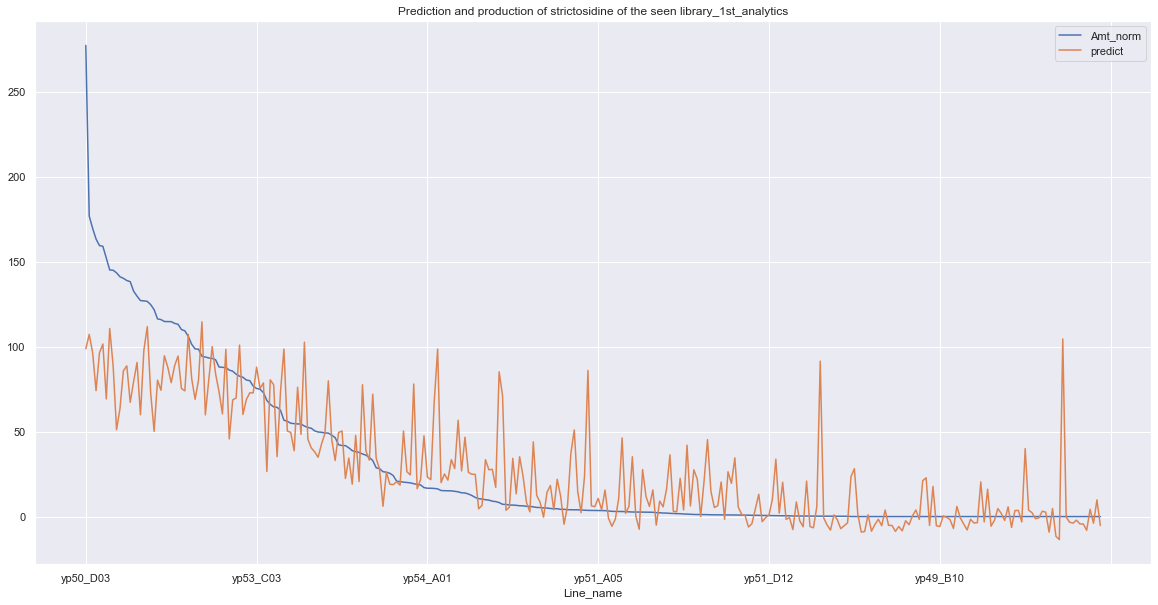

In [80]:
sns.set_context("paper", rc={"font.size":55,"axes.titlesize":5,"axes.labelsize":5}) 
sns.set(rc = {'figure.figsize':(30,10) })
df3.plot(y = ['Amt_norm','predict'], x =  'Line_name', figsize = (20,10))

ax = plt.gca()
ax.set_title("Prediction and production of strictosidine of the seen library_1st_analytics")

name = 'Prediction of the sampled library lineplot'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.svg',format = 'SVG',  dpi = 120)

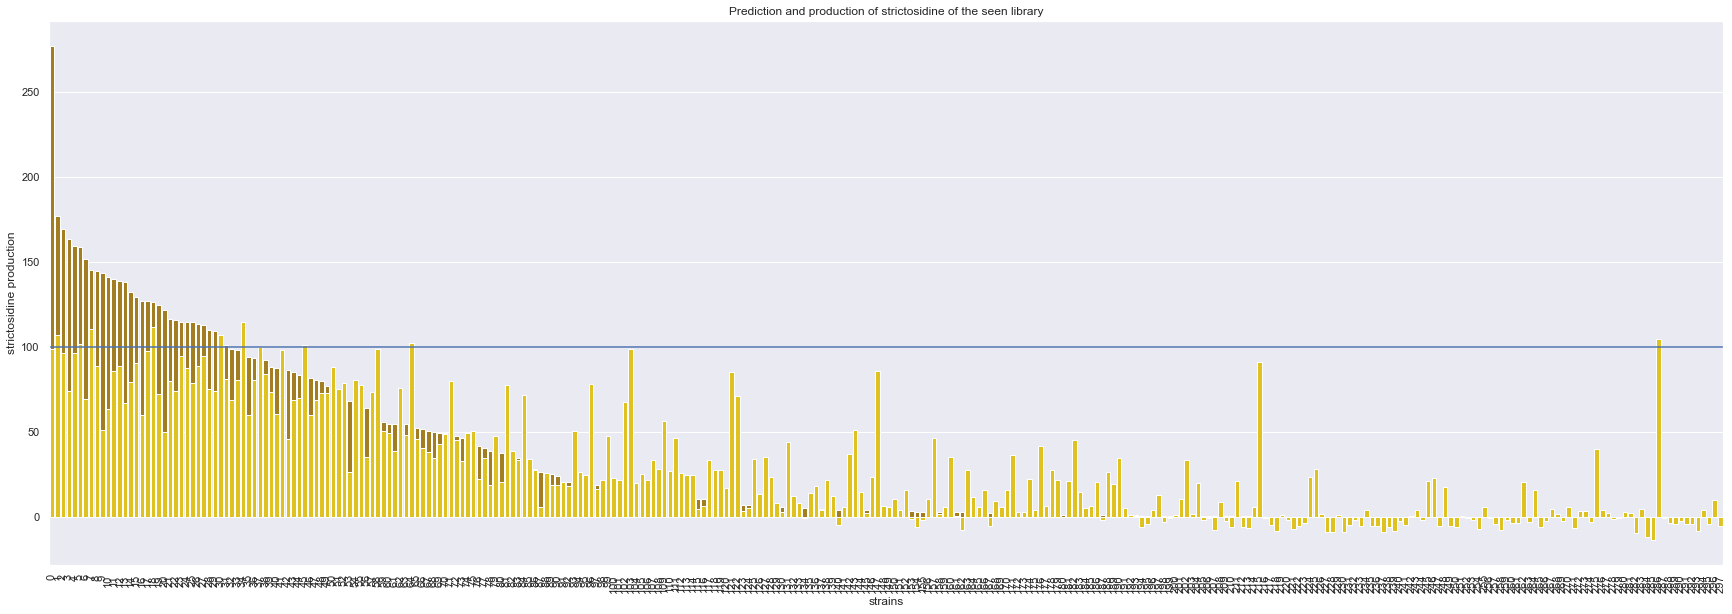

In [81]:
import matplotlib.pyplot as plt
sns.set_context("paper", rc={"font.size":55,"axes.titlesize":5,"axes.labelsize":5}) 
sns.set(rc = {'figure.figsize':(30,10) })


#creating subplots
ax=plt.subplots()
 
#plotting columns
ax=sns.barplot(x=df3.index,y=df3["Amt_norm"],color = 'darkgoldenrod')
ax=sns.barplot(x=df3.index,y=df3["predict"],color = 'gold')

 
#renaming the axes
ax.set(xlabel="strains", ylabel="strictosidine production")
plt.xticks(rotation=90)

ax = plt.gca()
ax.set_title("Prediction and production of strictosidine of the seen library")
ax.axhline(100)


name = 'Prediction of the sampled library_stacked_bar_1st_analytics"'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.svg',format = 'SVG',  dpi = 120)


 
# visualizing illustration
plt.show()

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_4557/3082259369.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds2['category'] = 'Predicted'
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_4557/3082259369.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds1['category'] = 'Strictosidine'


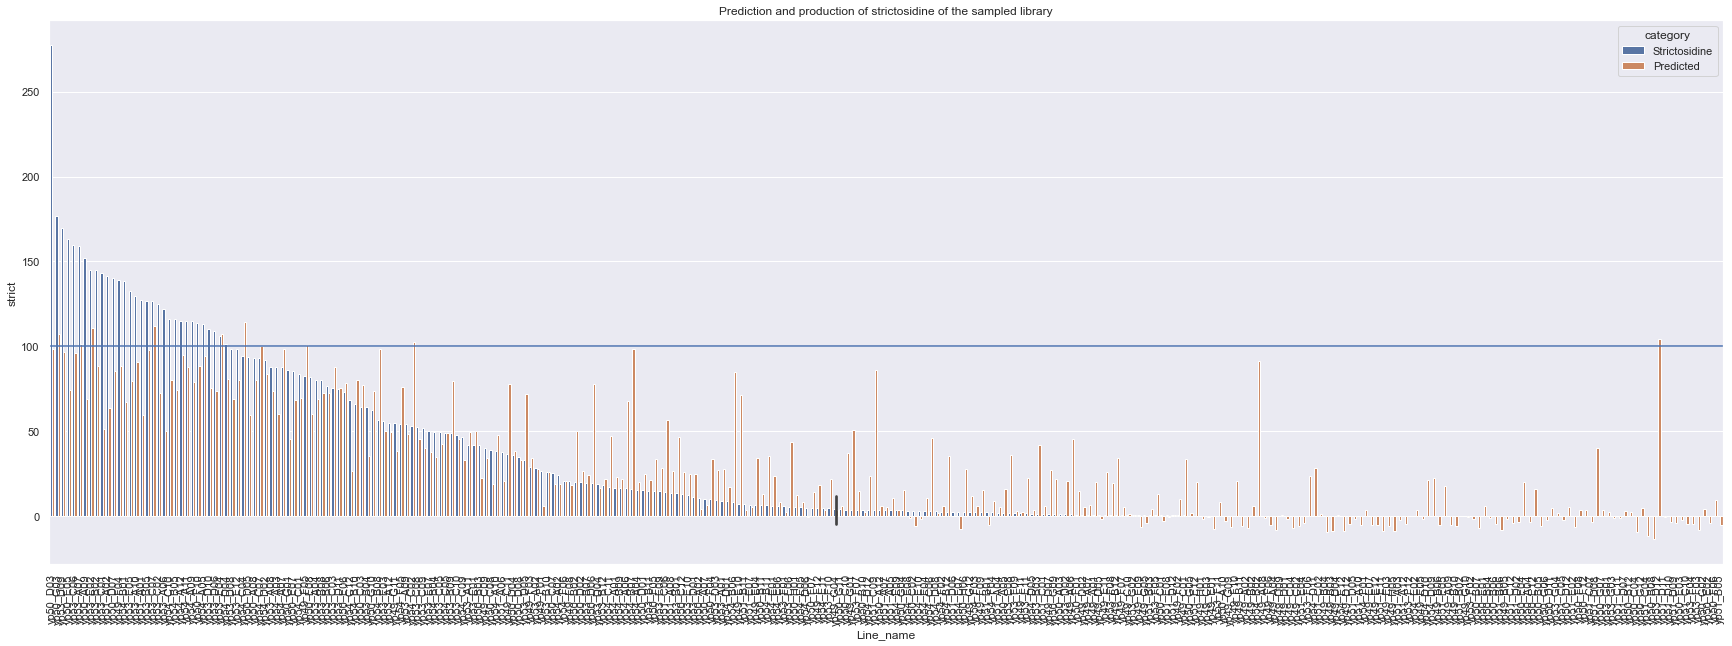

In [82]:
sns.set(rc = {'figure.figsize':(30,10) })


ds1 = df3[['Line_name', 'Amt_norm']]
ds1.columns = ['Line_name', 'strict']

ds2 = df3[['Line_name', 'predict']]
ds2.columns = ['Line_name', 'strict']


ds2['category'] = 'Predicted'
ds1['category'] = 'Strictosidine'
dss = pd.concat([ds1, ds2])

ax = sns.barplot(x='Line_name', y='strict', hue='category', data=dss)

ax = plt.gca()
ax.set_title("Prediction and production of strictosidine of the sampled library")
plt.xticks(rotation=90)
ax.axhline(100)
#ax.add_line
name = 'Prediction of the sampled library_1st_analytics"'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.svg',format = 'SVG',  dpi = 120)


None


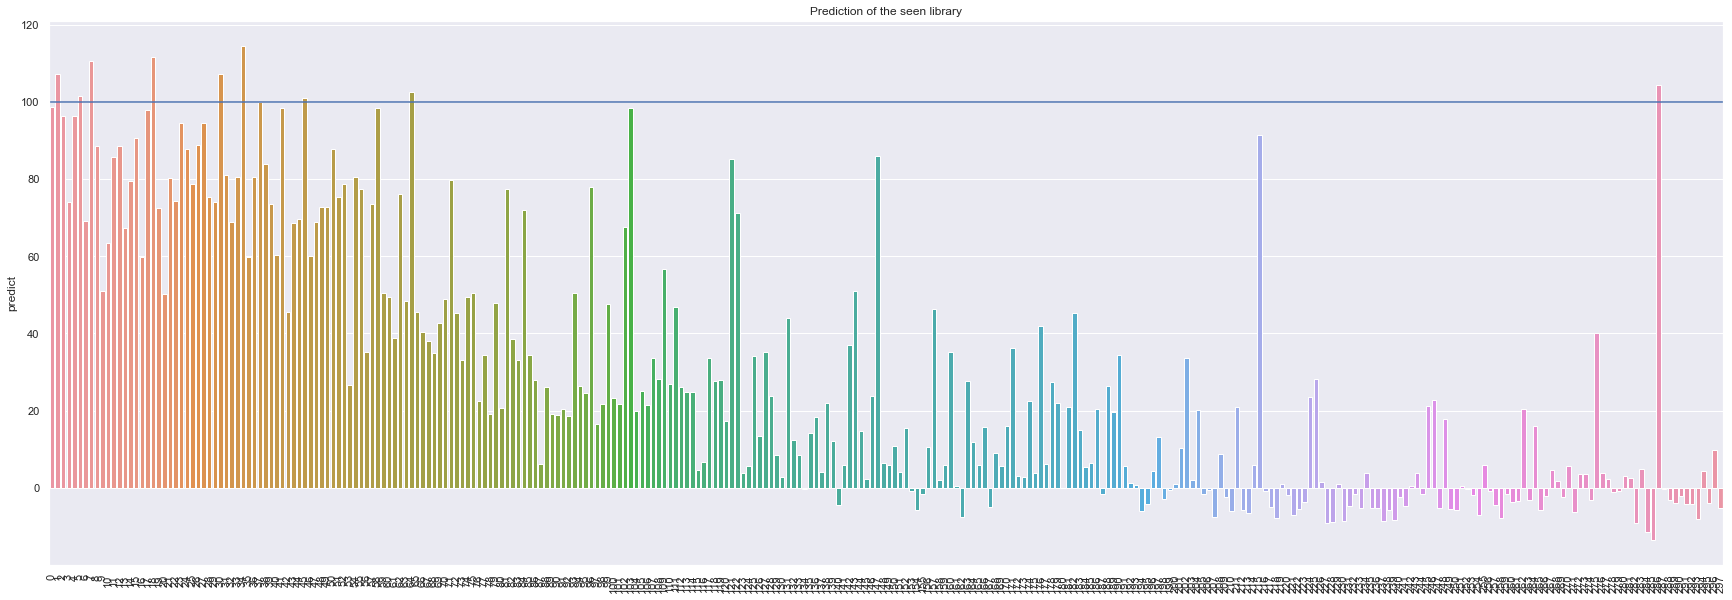

In [83]:
sns.set(rc = {'figure.figsize':(30,10) })

histogram = sns.barplot(data=df3, x=df3.index, y='predict')
histogram.axhline(100)
ax = plt.gca()
ax.set_title("Prediction of the seen library")

#plt.xticks(rotation=90)
histogram.set_xticklabels(histogram.get_xticklabels(), rotation=90)


name = 'Prediction of the sampled library_1st_analytics"'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.svg',format = 'SVG',  dpi = 120)


# this makes sure the labels are not shown
None

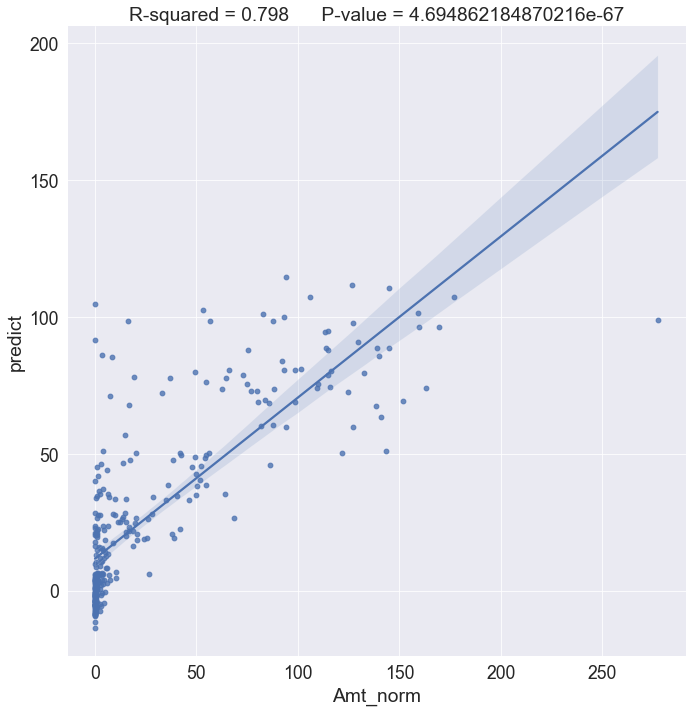

In [84]:
import seaborn as sns
from scipy.stats import pearsonr
import scipy as sp
from scipy import stats

#set seaborn plotting aesthetics as default
sns.set_context("paper", font_scale=2.0, rc={"lines.linewidth": 1.5})

g = sns.lmplot(data=df3, x="Amt_norm", y="predict",  palette="viridis", fit_reg = True, height=10)
r, p = stats.pearsonr(df3['Amt_norm'], df3['predict'])


ax = plt.gca()
ax.set_title(f"R-squared = {r:.3f}      P-value = {p}")

name = 'predicted_vs_amtnorm_corr_1st_analytics"'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.svg',format = 'SVG',  dpi = 120)


None

### 4.2 Learning curve

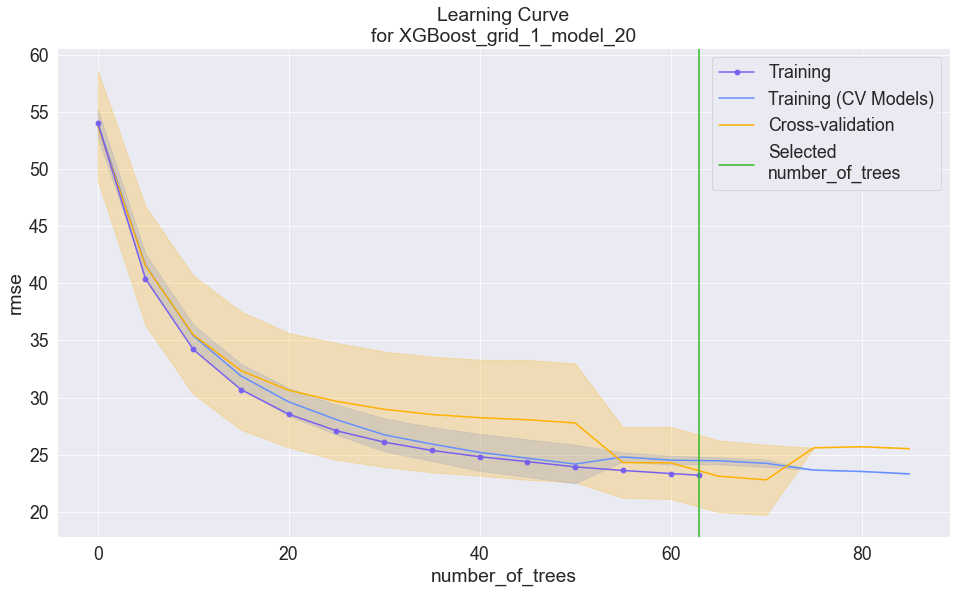

In [85]:

learning_curve = uploaded_model.learning_curve_plot()

#plt.title('Number of records by State')
None

In [86]:
as_data_frame_df_test

,Line_name,0,1,2,3,Amt_norm
0,yp50_D03,5,2,6,3,277.307816
1,yp49_F04,3,2,6,2,138.940568
2,yp53_E02,6,2,6,5,145.152656
3,yp53_A07,5,2,6,2,159.059724
4,yp53_C07,6,2,6,4,126.638026
...,...,...,...,...,...,...
293,yp54_D09,5,1,6,6,0.000000
294,yp54_D10,5,1,6,6,0.000000
295,yp49_E05,2,3,7,8,0.000000
296,yp54_E02,6,1,6,6,0.000000


### 4.3 Find predicted genotypes

In [87]:
import numpy as np

In [88]:
all_genotypes = pd.read_csv('ConStrain_on_google_colab/Data/processed/remaining_genotypes_after_first_iteration.csv',)
all_genotypes =all_genotypes[['0','1','2','3']]
all_genotypes

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
2,1,1,5,4
3,1,1,5,5
4,1,1,5,7
...,...,...,...,...
1117,8,4,8,6
1118,8,4,8,7
1119,8,4,8,8
1120,8,4,8,9


In [89]:
all_genotypes_df = h2o.H2OFrame(pd.concat([all_genotypes], axis='columns'))
all_genotypes_df

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


0,1,2,3
1,1,5,1
1,1,5,2
1,1,5,4
1,1,5,5
1,1,5,7
1,1,5,8
1,1,5,9
1,1,6,1
1,1,6,2
1,1,6,3


In [90]:
#merge_ = pd.merge(new_input_for_ml,all_genotypes, on= ['0','1','2','3'])
#merge_
new_input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/processed/input_for_ml_2nd_iteration.csv',  index_col=False)

input_fixed = new_input_for_ml[['0','1','2','3']]
input_fixed

,0,1,2,3
0,4,1,5,2
1,4,1,5,2
2,4,2,5,2
3,5,1,5,2
4,5,1,5,2
...,...,...,...,...
122,7,2,5,7
123,7,2,5,7
124,7,2,6,7
125,4,2,5,2


### 4.4 Getting rid of the genotypes we have already tested:

In [91]:
df_diff = all_genotypes[~all_genotypes.apply(tuple,1).isin(input_fixed.apply(tuple,1))]
#df_diff.to_csv('../data/processed/remaining_genotypes_after_first_iteration.csv')
df_diff

,0,1,2,3
0,1,1,5,1
1,1,1,5,2
2,1,1,5,4
3,1,1,5,5
4,1,1,5,7
...,...,...,...,...
1117,8,4,8,6
1118,8,4,8,7
1119,8,4,8,8
1120,8,4,8,9


In [92]:
# make the diff into a df 
all_genotypes_df = h2o.H2OFrame(pd.concat([df_diff], axis='columns'))
all_genotypes_df['0']= all_genotypes_df['0'].asfactor()
all_genotypes_df['1']= all_genotypes_df['1'].asfactor()
all_genotypes_df['2'] = all_genotypes_df['2'].asfactor()
all_genotypes_df['3'] = all_genotypes_df['3'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [93]:
predicted = best_model.predict(all_genotypes_df)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [94]:
len(predicted)

1049

In [95]:
predicted_norm = predicted.as_data_frame()
predicted_norm.head()

,predict
0,-8.786737
1,-2.118069
2,1.412734
3,-2.458081
4,-7.706130


In [96]:
# making predictions into a list
predicted_list = predicted_norm['predict'].values.tolist()

# Adding predictions to our dataframe
df_diff['predicted_norm_strict'] = predicted_list

# Sorting the dataframe
predicted_merged_sorted = df_diff.sort_values('predicted_norm_strict', ascending=False)
predicted_merged_sorted

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_4557/105107836.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['predicted_norm_strict'] = predicted_list


,0,1,2,3,predicted_norm_strict
610,5,2,6,4,112.699509
614,5,2,6,8,112.527802
615,5,2,6,9,111.868591
748,6,2,6,2,111.428070
753,6,2,6,9,109.073120
...,...,...,...,...,...
65,1,2,8,7,-13.280563
1009,8,1,7,10,-13.308126
56,1,2,7,7,-14.189703
451,4,1,7,10,-14.618565


If we want the names on the genotypes we can do the following: 

In [97]:
g8h_list_of_index = ["Cacu", "Opum","Cro","Vmin","Smus","Rsep","Oeu","Ccal"]
cpr_list_of_index = ["Cro", "Aan","Ara","Clo","Rse","Ahu","Ani","Cac","Oeu","Cpo"]
promoters = ["CYC1", "ENO2","PCK1","RPL15B", "CCW12", "TPI1","MLS1","URE2"]

g8h_genotype = []
cpr_genotype = []

pg8h_genotype = []
pcpr_genotype = []

predicted_list = []
# adding index of genotypes to individual rows 
for index, row in predicted_merged_sorted.iterrows():
    g8h_genotype.append(g8h_list_of_index[int(row['0'])-1])
    cpr_genotype.append(cpr_list_of_index[int(row['3'])-1])
    pg8h_genotype.append(promoters[int(row['1'])-1])
    pcpr_genotype.append(promoters[int(row['2'])-1])
    predicted_list.append(row['predicted_norm_strict'])
    
    
list_of_lists = [g8h_genotype,pg8h_genotype,pcpr_genotype, cpr_genotype, predicted_list  ]

## 5. Top 20 predicted producers

In [101]:
df_with_genotypes = pd.DataFrame(list_of_lists )
df_with_genotypes = df_with_genotypes.T
df_with_genotypes.columns = ['G8H', 'pG8H', 'pCPR', 'CPR', 'Predicted_strict_production']
df_with_genotypes.head(20)



,G8H,pG8H,pCPR,CPR,Predicted_strict_production
0,Smus,ENO2,TPI1,Clo,112.699509
1,Smus,ENO2,TPI1,Cac,112.527802
2,Smus,ENO2,TPI1,Oeu,111.868591
3,Rsep,ENO2,TPI1,Aan,111.42807
4,Rsep,ENO2,TPI1,Oeu,109.07312
5,Smus,ENO2,CCW12,Ara,107.933693
6,Rsep,ENO2,TPI1,Cac,107.873367
7,Smus,ENO2,CCW12,Clo,105.517082
8,Cro,ENO2,TPI1,Ara,105.39489
9,Smus,ENO2,CCW12,Aan,104.282814


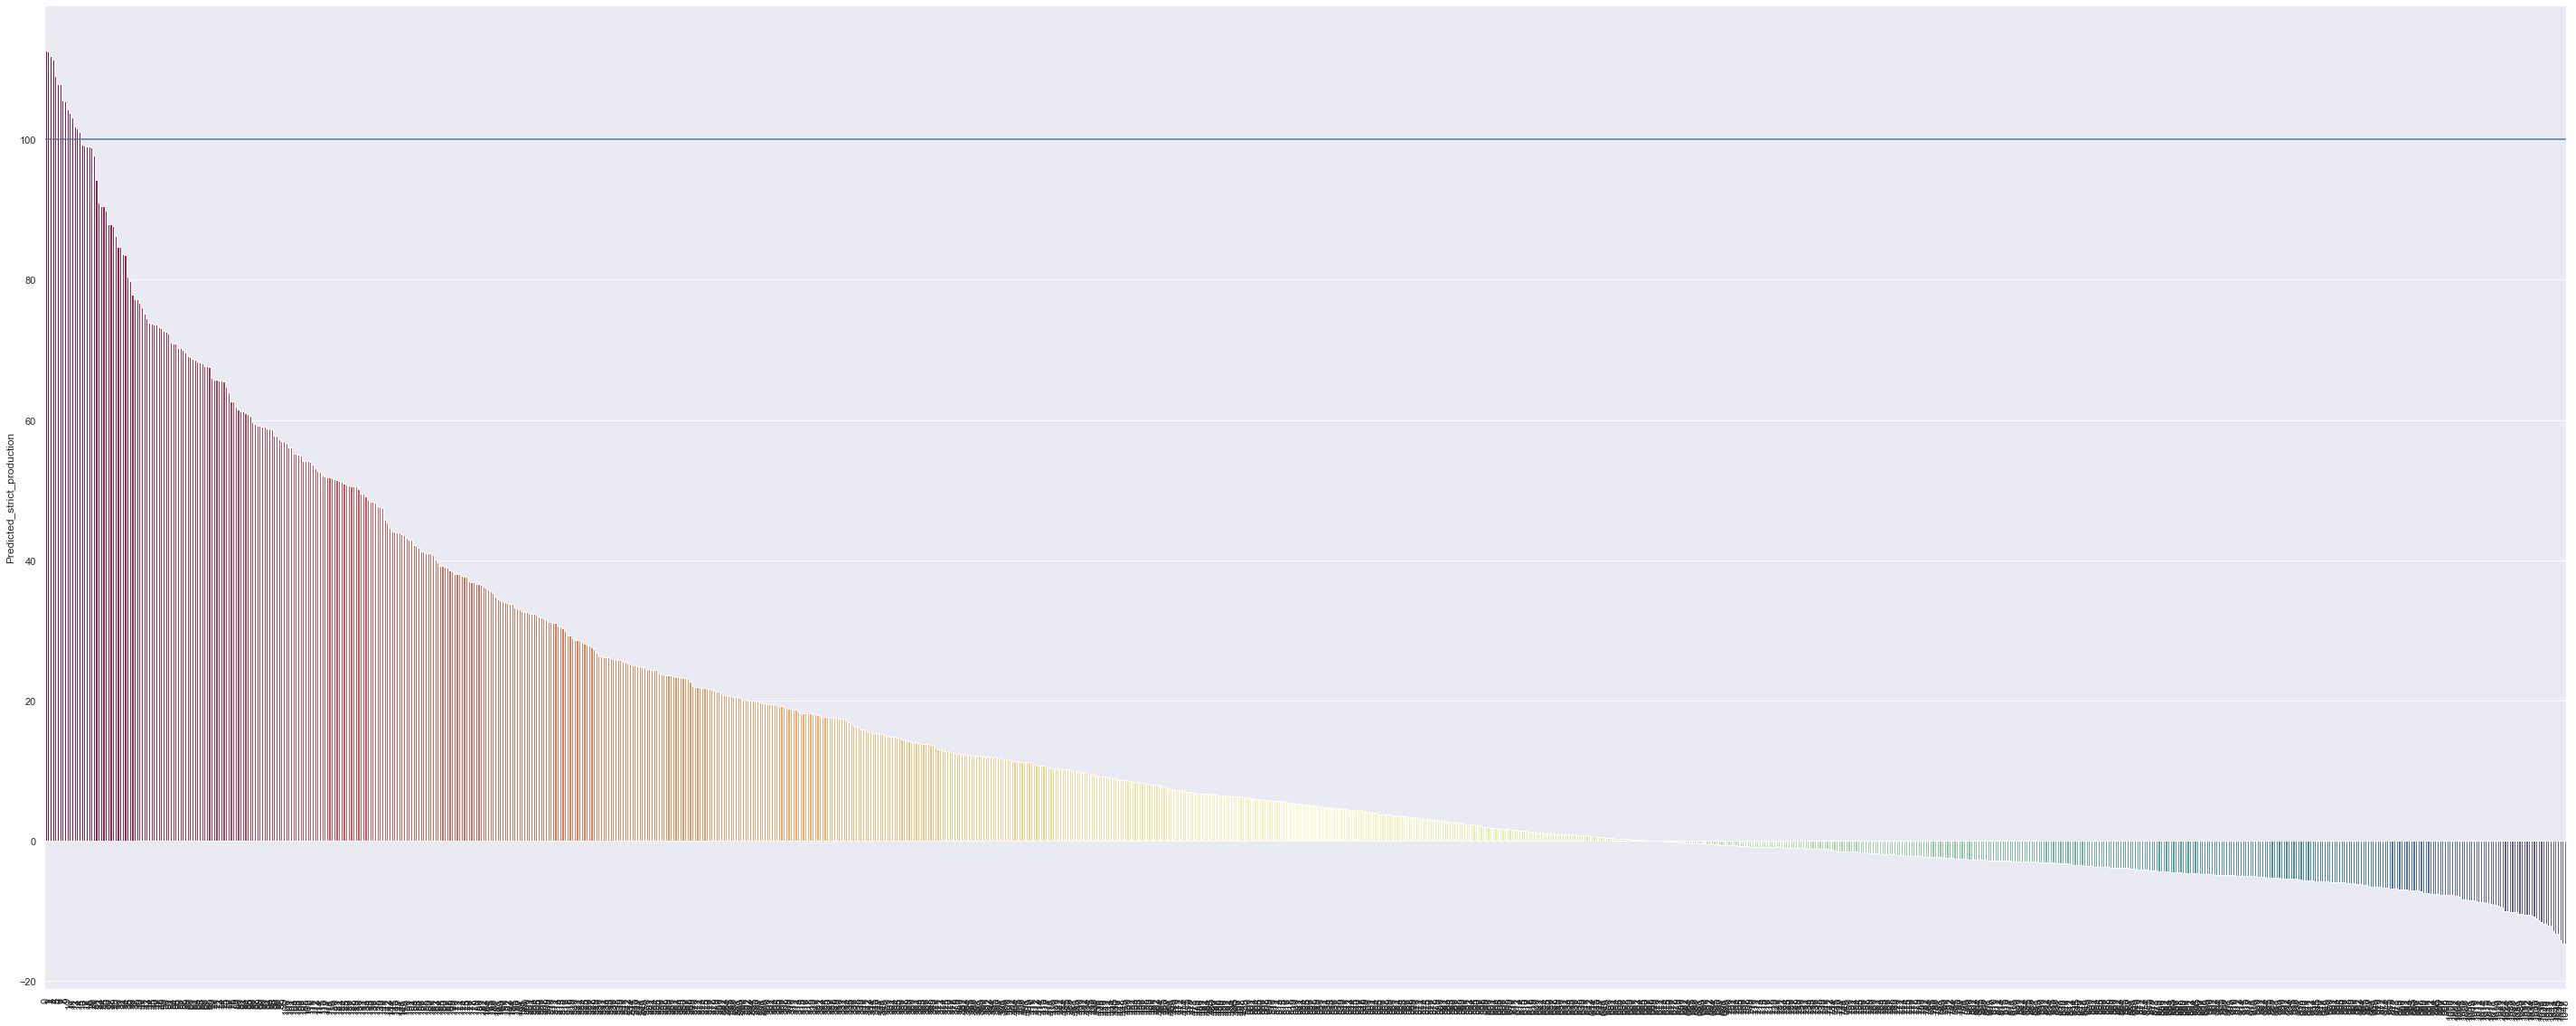

In [102]:
sns.set(rc = {'figure.figsize':(50,20) })

histogram = sns.barplot(data=df_with_genotypes, x=df_with_genotypes.index, y='Predicted_strict_production', palette= "Spectral")

histogram.axhline(100)

histogram.set_xticklabels(histogram.get_xticklabels(), rotation=90)

name = 'Predicted strict production of all unseen genotype_1st_analytics'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/ML_DBTL2/'+name+'.svg',format = 'SVG',  dpi = 120)

# this makes sure the labels are not shown
None

In [103]:
df_with_genotypes.to_csv('ConStrain_on_google_colab/Data/AutoML/top20_ML_predicted_after_second_DBTL_1st_analytics.csv', index=False)